#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [22]:
df_stock1 = pd.read_csv("../static/data/anz.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
8854,25/07/2022,22.590000,22.639999,22.450001,22.620001,22.620001,6321893.0,1.35,1.75,125.0
8855,26/07/2022,22.809999,23.020000,22.639999,22.639999,22.639999,6230924.0,1.35,2.50,125.0
8856,27/07/2022,22.500000,22.830000,22.370001,22.730000,22.730000,4600785.0,1.35,2.50,125.0
8857,28/07/2022,22.750000,22.920000,22.580000,22.700001,22.700001,4857205.0,1.35,2.50,125.0
8858,29/07/2022,22.799999,22.980000,22.730000,22.900000,22.900000,7594137.0,1.35,2.50,125.0


In [23]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.anz.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.anz.insert_many(records)

In [24]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.anz.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.anz.delete_one(
    {'Date': last_date}
)


DELETE: 29/07/2022 22.9


In [25]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.anz.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 28/07/2022 22.700001
Previous last date in MongoDb: 28-07-2022. Today's date: 03-08-2022


In [26]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'ANZ.AX'
start = from_date # yyyy-mm-dd

end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-28,22.920000,22.580000,22.750000,22.700001,4857205,22.700001
2022-07-29,22.980000,22.730000,22.799999,22.900000,7594137,22.900000
2022-08-01,22.799999,22.420000,22.799999,22.740000,7611230,22.740000
2022-08-02,22.860001,22.410000,22.440001,22.809999,6999769,22.809999
2022-08-03,22.770000,22.459999,22.590000,22.709999,5322088,22.709999


In [27]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-29,22.980000,22.730000,22.799999,22.900000,7594137,22.900000
2022-08-01,22.799999,22.420000,22.799999,22.740000,7611230,22.740000
2022-08-02,22.860001,22.410000,22.440001,22.809999,6999769,22.809999
2022-08-03,22.770000,22.459999,22.590000,22.709999,5322088,22.709999


In [28]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_23088/1960956411.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_23088/1960956411.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_23088/1960956411.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/07/2022,22.980000,22.730000,22.799999,22.900000,7594137,22.900000,1.35,2.5,125
1,01/08/2022,22.799999,22.420000,22.799999,22.740000,7611230,22.740000,1.35,2.5,125
2,02/08/2022,22.860001,22.410000,22.440001,22.809999,6999769,22.809999,1.35,2.5,125
3,03/08/2022,22.770000,22.459999,22.590000,22.709999,5322088,22.709999,1.35,2.5,125


UPDATE MONGO DB

In [29]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/07/2022',
  'High': 22.979999542236328,
  'Low': 22.729999542236328,
  'Open': 22.799999237060547,
  'Close': 22.899999618530273,
  'Volume': 7594137,
  'Adj Close': 22.899999618530273,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '01/08/2022',
  'High': 22.799999237060547,
  'Low': 22.420000076293945,
  'Open': 22.799999237060547,
  'Close': 22.739999771118164,
  'Volume': 7611230,
  'Adj Close': 22.739999771118164,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '02/08/2022',
  'High': 22.860000610351562,
  'Low': 22.40999984741211,
  'Open': 22.440000534057617,
  'Close': 22.809999465942383,
  'Volume': 6999769,
  'Adj Close': 22.809999465942383,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '03/08/2022',
  'High': 22.770000457763672,
  'Low': 22.459999084472656,
  'Open': 22.59000015258789,
  'Close': 22.709999084472656,
  'Volume': 5322088,
  'Adj Close': 22.709999084472656,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125}]

In [30]:
#INSERT NEW DATA INTO MONGODB
db.anz.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.anz.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('62ea3643da2eea6fc9279b20') '21/07/2022' 22.32 22.34 21.27
  21.93 21.93 17547203.0 1.35 1.75 125.0]
 [ObjectId('62ea3643da2eea6fc9279b21') '22/07/2022' 21.85 22.74 21.799999
  22.59 22.59 14715017.0 1.35 1.75 125.0]
 [ObjectId('62ea3643da2eea6fc9279b22') '25/07/2022' 22.59 22.639999
  22.450001 22.620001 22.620001 6321893.0 1.35 1.75 125.0]
 [ObjectId('62ea3643da2eea6fc9279b23') '26/07/2022' 22.809999 23.02
  22.639999 22.639999 22.639999 6230924.0 1.35 2.5 125.0]
 [ObjectId('62ea3643da2eea6fc9279b24') '27/07/2022' 22.5 22.83 22.370001
  22.73 22.73 4600785.0 1.35 2.5 125.0]
 [ObjectId('62ea3643da2eea6fc9279b25') '28/07/2022' 22.75 22.92 22.58
  22.700001 22.700001 4857205.0 1.35 2.5 125.0]
 [ObjectId('62ea3645da2eea6fc9279b27') '29/07/2022' 22.799999237060547
  22.979999542236328 22.729999542236328 22.899999618530273
  22.899999618530273 7594137.0 1.35 2.5 125.0]
 [ObjectId('62ea3645da2eea6fc9279b28') '01/08/2022' 22.799999237060547
  22.799999237060547 22.420000076293945 

In [31]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

03/08/2022 22.709999084472656


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [32]:
df_mongo = pd.DataFrame(list(db.anz.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(8698, 1)

In [33]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [34]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(6959, 1)

In [35]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01592121, 0.01592121, 0.01592121, 0.01592121, 0.01592121,
       0.01592121, 0.01592121, 0.01592121, 0.01592121, 0.01592121,
       0.01592121, 0.01592121, 0.01592121, 0.01592121, 0.01592121,
       0.01592121, 0.01592121, 0.01592121, 0.01592121, 0.01592121,
       0.02142814, 0.02142814, 0.02142814, 0.02142814, 0.02142814,
       0.02142814, 0.02142814, 0.02142814, 0.02142814, 0.02142814,
       0.02142814, 0.02142814, 0.02142814, 0.02142814, 0.02142814,
       0.02142814, 0.02142814, 0.02142814, 0.02142814, 0.02142814,
       0.02142814, 0.02142814, 0.03322874, 0.03322874, 0.03322874,
       0.03322874, 0.03322874, 0.03322874, 0.03322874, 0.03322874,
       0.03322874, 0.03322874, 0.03322874, 0.03322874, 0.03322874,
       0.03322874, 0.03322874, 0.03322874, 0.03322874, 0.03322874])]
[0.03322874361422559]


# Prepare train data for LSTM model

In [36]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(6899, 60)

In [37]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(6899, 60, 1)

# Build the LSTM model

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [39]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

6899/6899 [==============================] - 354s 51ms/step - loss: 6.6211e-04


In [41]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [42]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [43]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [44]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.3585118062541626

C:\Users\antoi\AppData\Local\Temp/ipykernel_23088/2328735313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


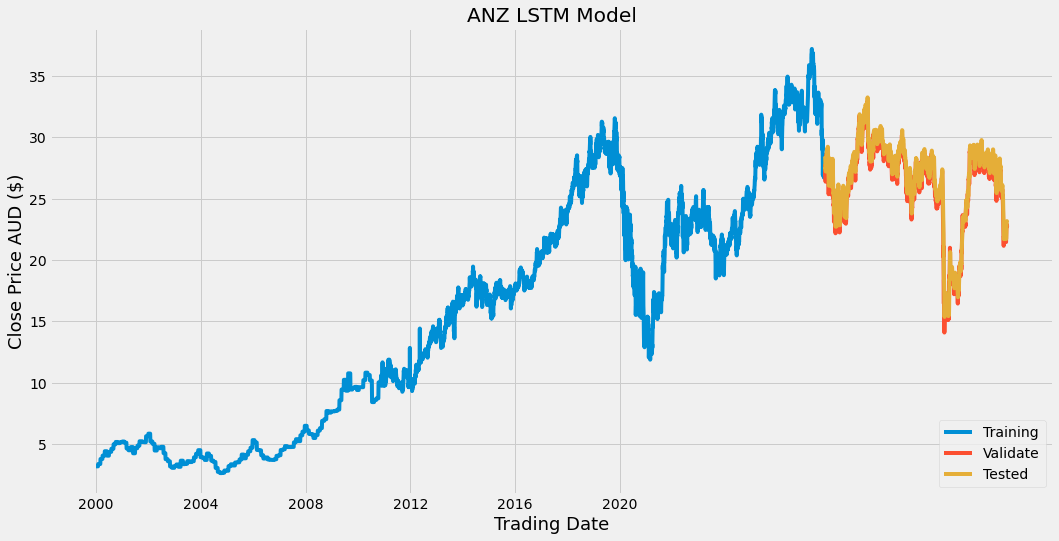

In [45]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('ANZ LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/anz_graph.png')
plt.show()

# Test data Predictions on the Model

In [46]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_23088/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
6959  27.830000    28.439266   -0.609266
6960  26.990000    28.321867   -1.331867
6961  27.340000    27.882114   -0.542114
6962  27.000000    27.671112   -0.671112
6963  27.400000    27.462154   -0.062154
...         ...          ...         ...
8693  22.700001    23.107769   -0.407768
8694  22.900000    23.127390   -0.227390
8695  22.740000    23.173174   -0.433174
8696  22.809999    23.134933   -0.324934
8697  22.709999    23.107565   -0.397566

[1739 rows x 3 columns]>

In [47]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.anz.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [48]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [49]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

03/08/2022 Last close $22.709999084472656 Predicted next day share price $22


# Save the Model

In [50]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/anz_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list anz_sixty and load df

#PREDICT USING LOADED MODEL

In [51]:
from keras.models import load_model
model_in = load_model('../static/anz_model.sav')

In [52]:
# query the anz collection and load into dataframe

df_mongo = pd.DataFrame(list(db.anz.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[25.264999  ],
       [25.09      ],
       [25.02      ],
       [25.385     ],
       [25.549999  ],
       [25.709999  ],
       [25.26      ],
       [25.219999  ],
       [25.24      ],
       [25.32      ],
       [25.309999  ],
       [25.51      ],
       [25.59      ],
       [25.57      ],
       [25.040001  ],
       [25.16      ],
       [24.92      ],
       [24.959999  ],
       [24.790001  ],
       [24.4       ],
       [23.799999  ],
       [23.129999  ],
       [23.01      ],
       [21.559999  ],
       [21.58      ],
       [21.43      ],
       [20.950001  ],
       [21.280001  ],
       [21.59      ],
       [21.780001  ],
       [21.870001  ],
       [21.75      ],
       [22.33      ],
       [22.129999  ],
       [22.290001  ],
       [22.030001  ],
       [22.        ],
       [22.209999  ],
       [21.969999  ],
       [22.030001  ],
       [22.370001  ],
       [22.639999  ],
       [22.440001  ],
       [22.302101  ],
       [22.173132  ],
       [21

#Create a function to loop through the days input

In [53]:
from keras.models import load_model
model_in = load_model('../static/anz_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_anz(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_anz(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[22.46,
 22.43,
 22.4,
 22.38,
 22.37,
 22.35,
 22.35,
 22.34,
 22.34,
 22.34,
 22.35,
 22.35,
 22.36,
 22.36,
 22.37,
 22.38,
 22.39,
 22.4,
 22.41,
 22.42,
 22.44,
 22.45,
 22.46,
 22.47,
 22.48,
 22.49,
 22.5,
 22.5,
 22.51,
 22.52,
 22.52,
 22.53,
 22.54,
 22.54,
 22.55,
 22.55,
 22.56,
 22.57,
 22.57,
 22.58,
 22.59,
 22.59,
 22.6,
 22.61,
 22.61,
 22.62,
 22.62,
 22.63,
 22.64,
 22.64,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.65,
 22.66,
 22.66,
 22.66,
 22.66,
 22.66,
 22.66,
 22.66,
 22.66,
 22.66,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.67,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.68,
 22.6

In [54]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  04-08-2022   Thursday
1        2  05-08-2022     Friday
2        3  08-08-2022     Monday
3        4  09-08-2022    Tuesday
4        5  10-08-2022  Wednesday
..     ...         ...        ...
203    204  16-05-2023    Tuesday
204    205  17-05-2023  Wednesday
205    206  18-05-2023   Thursday
206    207  19-05-2023     Friday
207    208  22-05-2023     Monday

[208 rows x 3 columns]>


In [55]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)


2022-07-28 00:00:00 2022-08-03 00:00:00
-7 days, 5:05:08.711920
[[ObjectId('62e112b2fb7cbba54bf62c9f') 199 '02-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca0') 200 '03-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca1') 201 '04-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca2') 202 '05-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca3') 203 '08-05-2023' 'Monday']
 [ObjectId('62e112b2fb7cbba54bf62ca4') 204 '09-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca5') 205 '10-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca6') 206 '11-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca7') 207 '12-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca8') 208 '15-05-2023' 'Monday']]


In [56]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,28-07-2022,Thursday
1,2,29-07-2022,Friday
2,3,01-08-2022,Monday
3,4,02-08-2022,Tuesday
4,5,03-08-2022,Wednesday
...,...,...,...
203,204,09-05-2023,Tuesday
204,205,10-05-2023,Wednesday
205,206,11-05-2023,Thursday
206,207,12-05-2023,Friday


In [57]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
# dates_df

C:\Users\antoi\AppData\Local\Temp/ipykernel_23088/1927354043.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


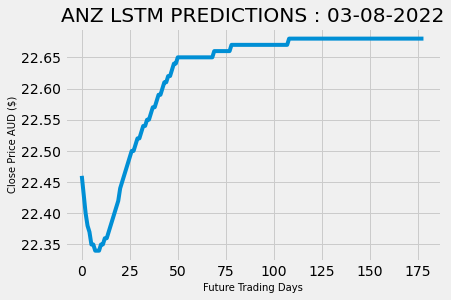

In [58]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('ANZ LSTM PREDICTIONS : '+today)
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/anz_pred.png', bbox_inches="tight")
plt.show()

In [59]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('62e112b2fb7cbba54bf62bd9'), 'Count': 1, 'Date': '28-07-2022', 'DOW': 'Thursday', 'Price': 22.46}


In [60]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


6959 8698 8875


C:\Users\antoi\AppData\Local\Temp/ipykernel_23088/82085094.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


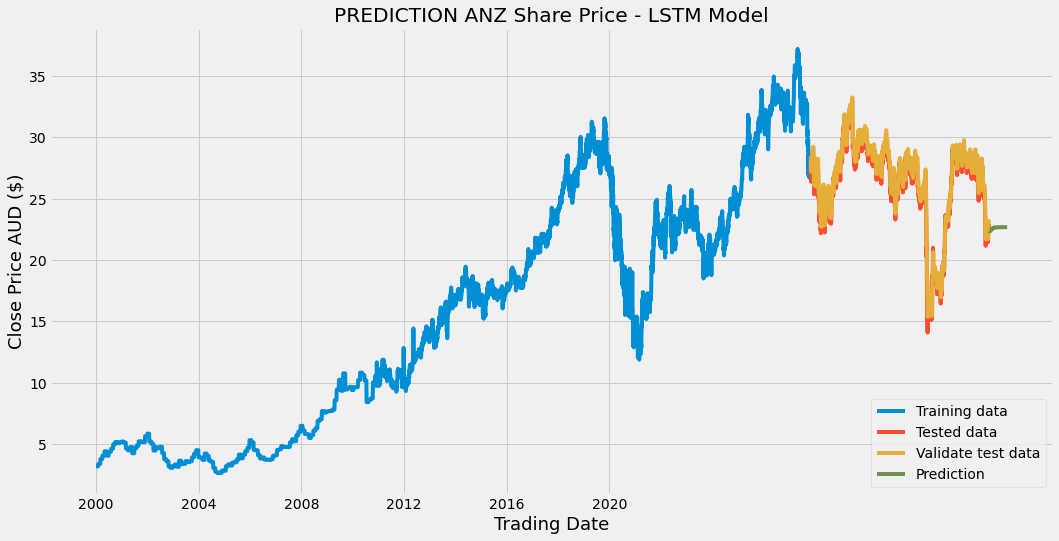

In [61]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION ANZ Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/anz_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [62]:
# Query all
name = 'ANZ'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e8dc2feec2ef8f24254be9'), 'model': 'LSTM', 'name': 'ANZ', 'date': '27-07-2022', 'predicted': 19, 'actual': 22.73, 'difference': -3.73, 'rmse': 3.47658}
{'_id': ObjectId('62e9b2c25c10aa6556d978cd'), 'model': 'RFR', 'name': 'ANZ', 'date': '02/08/2022', 'predicted': 33, 'actual': 22, 'difference': 11.055, 'accuracy': 97.12}


In [63]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e9b2c25c10aa6556d978cd'), 'model': 'RFR', 'name': 'ANZ', 'date': '02/08/2022', 'predicted': 33, 'actual': 22, 'difference': 11.055, 'accuracy': 97.12}


In [64]:
# Set keys and values of company
name = 'ANZ'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 03/08/2022,predicted $22, actual $22.71, difference -0.7100000000000009, rmse 0.35851


In [65]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e9b2c25c10aa6556d978cd'), 'model': 'RFR', 'name': 'ANZ', 'date': '02/08/2022', 'predicted': 33, 'actual': 22, 'difference': 11.055, 'accuracy': 97.12}
{'_id': ObjectId('62ea37dfda2eea6fc9279b2b'), 'model': 'LSTM', 'name': 'ANZ', 'date': '03/08/2022', 'predicted': 22, 'actual': 22.71, 'difference': -0.71, 'rmse': 0.35851}


In [66]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e236dd0512e77444960bd6'), 'model': 'RFR', 'name': 'NIC', 'date': '28/07/2022', 'predicted': 0.92, 'actual': 1.09, 'differece': -0.170910457265107, 'accuracy': 91.93}
{'_id': ObjectId('62e344e41db0d4fd35f906fc'), 'model': 'RFR', 'name': 'BHP', 'date': '28/07/2022', 'predicted': 46, 'actual': 37, 'differece': 9.531186964187029, 'accuracy': 96.63}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '

In [67]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e236dd0512e77444960bd6'), 'model': 'RFR', 'name': 'NIC', 'date': '28/07/2022', 'predicted': 0.92, 'actual': 1.09, 'differece': -0.170910457265107, 'accuracy': 91.93}
{'_id': ObjectId('62e344e41db0d4fd35f906fc'), 'model': 'RFR', 'name': 'BHP', 'date': '28/07/2022', 'predicted': 46, 'actual': 37, 'differece': 9.531186964187029, 'accuracy': 96.63}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '